# Solution 1.X. - Assessing the OLS Model
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

# 1 Multivariate Regression

This problem utilizes the data in `../data/multi_asset_etf_data.xlsx`.
* Return data on various asset classes.
* This data comes via ETFs, which we will discuss in the Markets series.

## 1.1 Correlation

Calculate and display the correlation matrix of the returns.

Consider displaying it with `seaborn.heatmap`.

Which pair has the highest correlation? And the smallest (most negative)?

## 1.2 Multivariate Regression

Suppose that we want to decompose `PSP` into a linear combination of other asset classes.
* `PSP` is a benchmark of private equity returns.
* There is substantial research (and controversy) as to whether private equity returns can be produced from other simple assets.
* We will see.

$$r_t^{\text{PSP}} = \alpha + \boldsymbol{\beta}\boldsymbol{r}_t + \epsilon_t$$

where $\boldsymbol{r}_t$ denotes the vector of all the other returns (excluding PSP) at time $t$.

Report
* the estimated alpha
* the estimated betas
* the r-squared

#### Python tip
Consider forming `X = rets.drop(columns=['PSP'])`.

Consider using one of the following for the regression.
* `statsmodels.OLS`
* `sklearn.linear_models.LinearRegression()`

The former will include various regression statistics. The latter will just produce the estimates.

## 1.3 Interpretation

Based on your estimates, do you think it is feasible to replicate `PSP` with these other assets? Be specific, citing your answers to the previous question. What does $\alpha$ indicate? What does the r-squared statistic indicate?

## 1.4 Multicollinearity

Should we be worried about multicollinearity in this case?

Calculate some metrics about $X'X$, (noting that in our case "$X$" is the array of return data, excluding `PSP`.

* determinant
* conditioning number

What do these metrics indicate?

#### Python tip
You may find these `numpy` functions helpful:
* `numpy.linalg.cond()`
* `numpy.linalg.det()`

## 1.5 Impact of multicollinearity

With multicollinearity, we are concerned that the regression estimates
* are imprecise.
* will change a lot in response to small changes in new data.
* will perform badly out of sample.

To investigate...
* report the t-stats of the betas

## 1.X Extra: 
Estimate the regression, but this time using only data through 2019. 
* Apply these estimated betas to the data in 2020-2022 to construct the replication of `PSP` ($\hat{y}$) out of sample.
* What is the correlation of PSP in 2020-2022 versus this out-of-sample regression estimate?

Graph `PSP` against the regression estimate, both through 2019 (in sample) and 2020-2022 (out of sample.)

# Appendix: Condition number of a matrix

$\newcommand{\olsb}{\boldsymbol{b}}$
$\newcommand{\olsy}{\boldsymbol{y}}$

Consider the linear equation

$$\olsy = a + X\olsb + e$$

Solving for $\olsb$,
$$(X'X)\olsb = X'\olsy$$

Denote the condition number of $X'X$ as $\kappa$.

Then,
$$\frac{||\delta \olsb||}{||\olsb||} \le \kappa \frac{||\delta X'\olsy||}{||X'\olsy||}$$

#### This says that 
- estimation error of size $\delta$ in the covariation of $X$ and $\olsy$ 
- will lead to errors up to size $\kappa\delta$ in the estimation of $\olsb$.

# 2 Heteroskedasticity \& Serial Correlation

$$\newcommand{\rspyt}{r_{\text{spy}}}$$
$$\newcommand{\rspyt}{r_{\text{spy},t}}$$

## Data

This problem uses the file, `../data/spy_rates_data.xlsx`.
* Return rates for SPY, the return on the S\&P 500. Denote this as $\rspyt$.
* Dividend-price ratio for the S\&P 500.
* 10-year yields on US Treasuries.

## 2.1
Use linear regression to calculate whether S\&P 500 returns (SPY) are impacted by 10-year yields and the dividend-price ratio.

$$\begin{align}
\rspyt = \alpha + \boldsymbol{\beta}'\boldsymbol{X}_t + \epsilon_t
\label{eq:spy_on_macro}
\end{align}$$

where $\boldsymbol{X}$ denotes the matrix of values of the 10-year-yield and the dividend-price ratio.

Report the betas.

## 2.2
Try using `statsmodels.OLS` to estimate the regression, and print the "summary" of the results which will show the t-stats, p-values, etc. Are either of the regressors are statistically significant?

## 2.3
Calculate the correlation between the sample residuals, $e_t$, and their lagged value, $e_{t-1}$. Are they highly correlated? You may find it helpful to use .shift in pandas to get the lagged series.

## 2.4
Calculate the regression of
$$e_t = \alpha + \boldsymbol{\beta}'\boldsymbol{X}_t + u_t$$

## 2.5
What do the previous two calculations have to do with identifying serial correlation and heteroskedasticity?

# <span style='color:red'>Solution 1</span>

In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [2]:
filepath_data = '../data/multi_asset_etf_data.xlsx'
info = pd.read_excel(filepath_data,sheet_name='descriptions')
info.rename(columns={'Unnamed: 0':'Symbol'},inplace=True)
info.set_index('Symbol',inplace=True)

rets = pd.read_excel(filepath_data,sheet_name='total returns')
rets.set_index('Date',inplace=True)
rets.drop(columns=['SHV'])

retsx = pd.read_excel(filepath_data,sheet_name='excess returns')
retsx.set_index('Date',inplace=True)

# sort columns by order of descriptions in Info tab
symbol_list = info.index.drop('SHV')
rets = rets[symbol_list]
retsx = retsx[symbol_list]

In [3]:
info

,ETF Description
Symbol,
SPY,Domestic Equity SPDR S&P500
EFA,Foreign Equity iShares EAFE
EEM,iShares Emerging Markets
PSP,Private Equity Invesco Global Private Equity
QAI,Absolute Return IQ Multi-Strat
HYG,High Yield iShares High Yield Corporate Bond
DBC,Invesco DB Commodity Index Tracking Fund
IYR,Real Estate iShares US Real Estate
IEF,Domestic Bonds iShares 7-10 Year Treasury


In [4]:
rets

,SPY,EFA,EEM,PSP,QAI,HYG,DBC,IYR,IEF,BWX,TIP
Date,,,,,,,,,,,
2009-04-30,0.0993,0.1152,0.1556,0.2302,0.0229,0.1385,-0.0010,0.2962,-0.0275,0.0090,-0.0180
2009-05-31,0.0585,0.1319,0.1594,0.0539,0.0279,0.0286,0.1627,0.0227,-0.0208,0.0537,0.0200
2009-06-30,-0.0007,-0.0140,-0.0225,0.0454,-0.0034,0.0335,-0.0263,-0.0249,-0.0056,0.0051,0.0020
2009-07-31,0.0746,0.1004,0.1101,0.1432,0.0153,0.0692,0.0186,0.1058,0.0083,0.0313,0.0009
2009-08-31,0.0369,0.0450,-0.0131,0.0334,-0.0042,-0.0170,-0.0404,0.1319,0.0076,0.0076,0.0084
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-31,-0.0527,-0.0363,-0.0002,-0.0860,-0.0208,-0.0265,0.0789,-0.0823,-0.0211,-0.0262,-0.0206
2022-02-28,-0.0295,-0.0343,-0.0432,-0.0736,-0.0067,-0.0086,0.0647,-0.0459,-0.0030,-0.0112,0.0086
2022-03-31,0.0376,0.0052,-0.0338,-0.0077,-0.0026,-0.0129,0.0917,0.0686,-0.0406,-0.0422,-0.0188


MIN Correlation pair is ('IEF', 'DBC')
MAX Correlation pair is ('EFA', 'PSP')


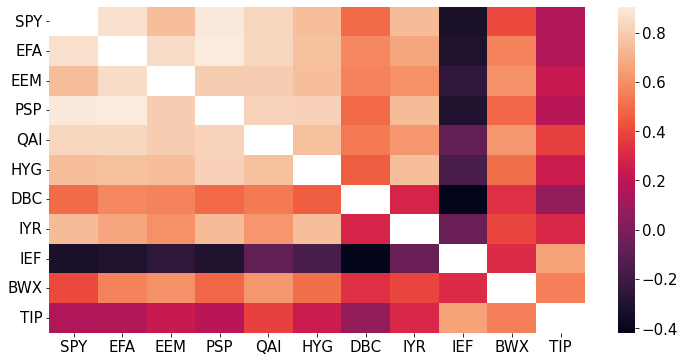

In [5]:
corrmat = retsx.corr()
#ignore self-correlation
corrmat[corrmat==1] = None
sns.heatmap(corrmat)

corr_rank = corrmat.unstack().sort_values().dropna()
pair_max = corr_rank.index[-1]
pair_min = corr_rank.index[0]

print(f'MIN Correlation pair is {pair_min}')
print(f'MAX Correlation pair is {pair_max}')

In [6]:
y = rets['PSP']
X_full = rets.drop(columns=['PSP'])
X_simple = rets[['SPY','TIP','IEF']]


X = X_full

mod = LinearRegression(fit_intercept=True).fit(X,y)

pe_replication = pd.DataFrame(index=X.columns, columns = ['beta'], data=mod.coef_)
pe_replication.T

,SPY,EFA,EEM,QAI,HYG,DBC,IYR,IEF,BWX,TIP
beta,0.4408,0.5755,-0.0213,0.2511,0.5281,-0.1185,0.0650,-0.4933,0.0469,0.3356


In [7]:
print(f'Regression R-squared is {mod.score(X,y):.1%}\n')
print(f'What is the correlation between the PE fund and the replicating portfolio?\n')

Regression R-squared is 89.8%

What is the correlation between the PE fund and the replicating portfolio?



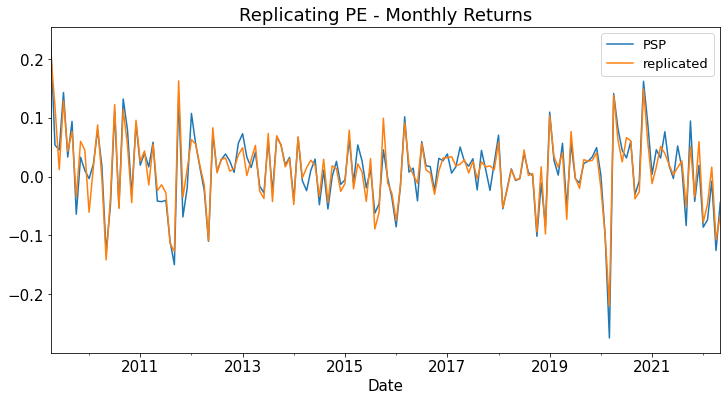

In [8]:
rets_replicated = pd.concat([y, pd.DataFrame(data=mod.predict(X),index=X.index, columns=['replicated'])],axis=1)
rets_replicated.plot(title='Replicating PE - Monthly Returns')
plt.show()

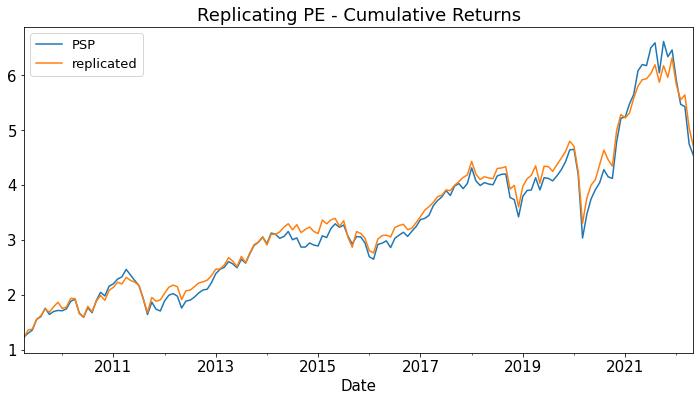

In [9]:
(rets_replicated+1).cumprod().plot(title='Replicating PE - Cumulative Returns')
plt.show()

In [10]:
X = X_simple
mod = LinearRegression(fit_intercept=True).fit(X,y)

pe_replication = pd.DataFrame(index=X.columns, columns = ['beta'], data=mod.coef_)
pe_replication.T

,SPY,TIP,IEF
beta,1.2816,0.6009,-0.4125


In [11]:
print(f'Regression R-squared is {mod.score(X,y):.1%}\n')
print(f'What is the correlation between the PE fund and the replicating portfolio?\n')

Regression R-squared is 81.2%

What is the correlation between the PE fund and the replicating portfolio?



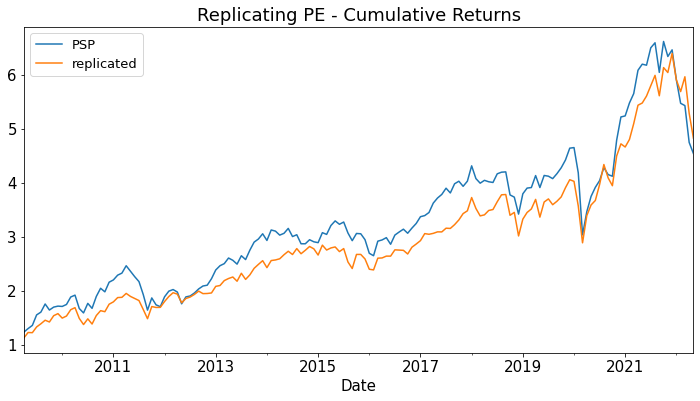

In [12]:
rets_replicated = pd.concat([y, pd.DataFrame(data=mod.predict(X),index=X.index, columns=['replicated'])],axis=1)
(rets_replicated+1).cumprod().plot(title='Replicating PE - Cumulative Returns')
plt.show()

In [13]:
print(f'Condition Number FULL replication: {np.linalg.cond(X_full.T@ X_full):.1f}\n')
print(f'Condition Number SIMPLE replication: {np.linalg.cond(X_simple.T@ X_simple):.1f}')

Condition Number FULL replication: 328.9

Condition Number SIMPLE replication: 40.0


In [14]:
print(f'Determinant FULL replication: {np.linalg.det(X_full.T@ X_full):.6f}\n')

print(f'Determinant SIMPLE replication: {np.linalg.det(X_simple.T@ X_simple):.6f}')

Determinant FULL replication: 0.000000

Determinant SIMPLE replication: 0.000139


# <span style='color:red'>Solution 2</span>

In [15]:
SPYFILE = '../data/spy_rate_data.xlsx'
data = pd.read_excel(SPYFILE).rename(columns={'Unnamed: 0':'date'}).set_index('date')

## 2.1-2.2

In [16]:
X = sm.add_constant(data[["10-yr Yields", "Dvd-Price Ratio"]])
y = data["SPY US Equity"]
mod = sm.OLS(y, X).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          SPY US Equity   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4.465
Date:                Tue, 09 Aug 2022   Prob (F-statistic):             0.0125
Time:                        18:39:18   Log-Likelihood:                 423.48
No. Observations:                 239   AIC:                            -841.0
Df Residuals:                     236   BIC:                            -830.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0741      0.023      3.191      0.002       0.028       0.120
10-yr Yields       -0.7707      0.280     -2.754      0.006      -1.322      -0.219
Dvd-Price Ratio    -2.2646      0.849     -2.669      0.008      -3.936      -0.593
==============================================================================
Omnibus:                        6.566   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.038   Jarque-Bera (JB):                6.427
Skew:                          -0.333   Prob(JB):                       0.0402
Kurtosis:                       3.448   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With t-ratios of -2.754 and -2.669, both regressors are statistically significant.

## 2.3

In [17]:
e = mod.resid
rho = e.corr(e.shift(1))

print(f'Serial correlation of residuals is {rho:.2%}.')

Serial correlation of residuals is 5.09%.


## 2.4

In [18]:
mod_resids = sm.OLS(e**2, X).fit()
mod_resids.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     8.172
Date:                Tue, 09 Aug 2022   Prob (F-statistic):           0.000370
Time:                        18:39:18   Log-Likelihood:                 1087.1
No. Observations:                 239   AIC:                            -2168.
Df Residuals:                     236   BIC:                            -2158.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0041      0.001     -2.840      0.005      -0.007      -0.001
10-yr Yields        0.0586      0.017      3.367      0.001       0.024       0.093
Dvd-Price Ratio     0.2053      0.053      3.887      0.000       0.101       0.309
==============================================================================
Omnibus:                      150.121   Durbin-Watson:                   1.572
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1029.503
Skew:                           2.511   Prob(JB):                    2.79e-224
Kurtosis:                      11.841   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 2.5

The regression of sample residuals (squared) is giving us information as to whether the residual variance is always the same distribution, (homoskedastic,) or whether it varies with different conditioning info, $X$, (heteroskedastic.) 

Thus, if any of the betas are significant, it tells us that the residuals are heteroskedastic.